# Imports

In [ ]:
! pip install pennylane

In [ ]:
import pandas
import numpy as np

from matplotlib import pyplot as plt
import itertools

import pennylane as qml
from pennylane import numpy as np_qml
from pennylane.optimize import NesterovMomentumOptimizer, RotosolveOptimizer, GradientDescentOptimizer, SPSAOptimizer

from sklearn.metrics.cluster import silhouette_score
from sklearn.cluster import SpectralClustering
from sklearn.metrics import rand_score, davies_bouldin_score
from sklearn.metrics.pairwise import euclidean_distances

from sklearn.datasets import make_moons, make_blobs, make_circles

from sklearn import cluster, preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import networkx as nx

# Circuitos

In [99]:
def adapt_circuits(NumberOfQubits_=2, NumberOfLayers_ = 3):
    global dev
    global qnode
    global circuit
    global NumberOfQubits
    global NumberOfLayers
    NumberOfQubits = NumberOfQubits_
    NumberOfLayers = NumberOfLayers_

    dev = qml.device('default.qubit', wires=NumberOfQubits)
    # dev = qml.device("lightning.gpu", wires=n_qubits)

    def layer(layer_weights, cnot_dir):
        for i, qubitWeights in enumerate(layer_weights):
            # print(qubitWeights)
            qml.Rot(*qubitWeights, wires=i)
        
        cnot_dir = -1 if cnot_dir == 0 else 1
        first = 0 if cnot_dir == 1 else 1
        for i in range(first, NumberOfQubits-1+first):
            qml.CRZ(phi=np.pi, wires=[i, (i+cnot_dir)%NumberOfQubits])

    def statepreparation(dtx):
        for i, rtx in enumerate(dtx):
            qml.RX(rtx, wires=i) # Assumindo que a entrada está normalizada em [-PI, PI]

    @qml.qnode(dev, interface="autograd")
    def circuit(weights, dtx):
        statepreparation(dtx)  # Carrega o input no circuito

        for i, layerW in enumerate(weights): # Cria o circuito
            layer(layerW, i%NumberOfQubits)

        return qml.expval(qml.PauliZ(0)) # Retorna o valor esperado
    
    qnode = qml.QNode(circuit, dev, interface="torch")

adapt_circuits()

In [18]:
def classifier(qnode, weights, bias, dtx):
  return qnode(weights, dtx) + bias

(<Figure size 1300x400 with 1 Axes>, <Axes: >)

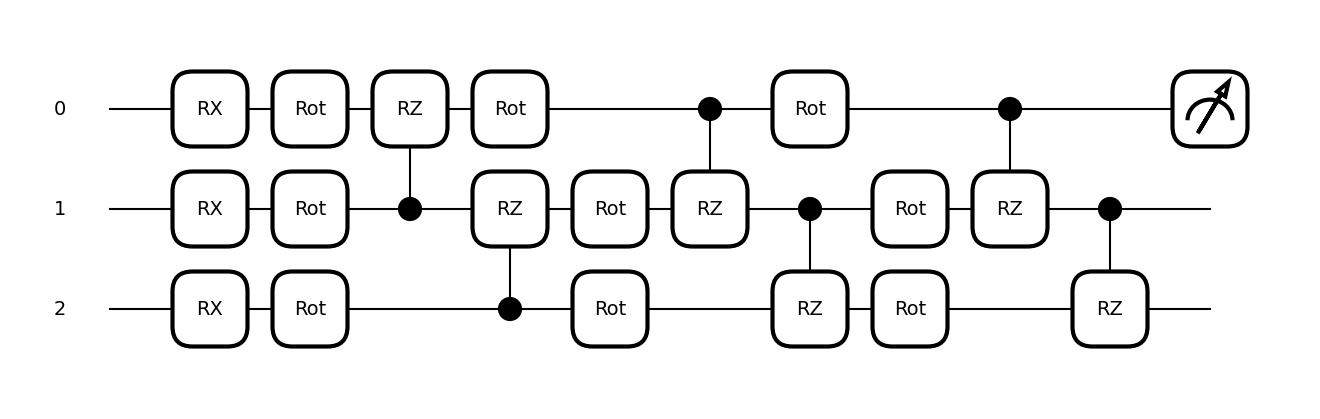

In [100]:
NumberOfQubits = 3
NumberOfLayers = 3
adapt_circuits(NumberOfQubits, NumberOfLayers)

# Definição dos pesos e bias iniciais
initial_weights = np_qml.random.randn(NumberOfLayers, NumberOfQubits, 3, requires_grad=True)
initial_bias = np_qml.array([0.0], requires_grad=True)
input_sample = np_qml.random.randn(NumberOfQubits, requires_grad=True)

# Desenho do circuito
qml.draw_mpl(circuit)(initial_weights, input_sample)

# Definições de perda e acurácia

In [ ]:
Modularity - Measures the strength of division of a graph into clusters by comparing the density of edges inside clusters vs. across clusters.
networkx.algorithms.community.quality.modularity

Conductance - Evaluates the quality of clusters by measuring the fraction of total edge volume that points outside a given cluster.
networkx.algorithms.cuts.conductance

In [95]:
def tanh_function(x, k=5):
    return np.tanh(k * x)

def cost(weights, bias, metric, X_batch, y_batch):
    predictions = np.array([classifier(qnode, weights, bias, Xi) for Xi in X_batch ] )
    predictions = predictions.reshape(1, len(predictions))
    return metric(X_batch, predictions, y_batch)

def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc


threshold_div = 1e-16
def threshold(val):
    if(val <= -threshold_div): return -1
    if(val >= +threshold_div): return +1
    return 0
# def threshold(val):
#     return np.where(val <= -threshold_div, -1, np.where(val >= threshold_div, 1, 0))

def squared_loss(X, y_predict, labels):
  return np.mean( (labels - qml.math.stack(y_predict)) ** 2)


def square_loss_silhouette(features, predictions, labels):
  if(len(predictions) == 1): predictions = np.array(predictions).reshape(len(predictions[0]), 1)
  predictions = np.array(list(map(threshold, predictions)))
  if len(np.unique(predictions)) == 1: return np.float16(1)
  return np.float16(1 - silhouette_score(features, predictions))


def square_loss_davies_bouldin_score(features, predictions, labels):
  if(len(predictions) == 1): predictions = np.array(predictions).reshape(len(predictions[0]), 1)
  predictions = np.array(list(map(threshold, predictions)))
  if len(np.unique(predictions)) == 1: return np_qml.float16(1)
  return np_qml.float16(davies_bouldin_score( features, predictions))


def graph_metric_normalized_cut(features, predictions, labels):
    if len(predictions) == 1: predictions = np.array(predictions).reshape(len(predictions[0]), 1)
    predictions = np.array(list(map(threshold, predictions)))
    if len(np.unique(predictions)) == 1: return np_qml.float16(1)
    
    affinity_matrix = np.exp(-euclidean_distances(features) ** 2)
    clustering = SpectralClustering(n_clusters=len(np.unique(predictions)), affinity='precomputed', assign_labels='discretize')
    labels = clustering.fit_predict(affinity_matrix)
    cut_value = np.sum(affinity_matrix[predictions != labels]) / np.sum(affinity_matrix)
    return np_qml.float16(cut_value)

def graph_metric_modularity(features, predictions, labels):
    if len(predictions) == 1: predictions = np.array(predictions).reshape(len(predictions[0]), 1)
    predictions = np.array(list(map(threshold, predictions)))
    if len(np.unique(predictions)) == 1: return np_qml.float16(0)
    
    affinity_matrix = np.exp(-euclidean_distances(features) ** 2)
    G = nx.from_numpy_array(affinity_matrix)
    
    # partition = {i: predictions[i] for i in range(len(predictions))}
    communities = [set(np.where(predictions == label)[0]) for label in np.unique(predictions)]
    modularity_score = nx.algorithms.community.quality.modularity(G, communities)
    
    return np_qml.float16(-modularity_score)

from sklearn.metrics import silhouette_samples
from sklearn.metrics.pairwise import pairwise_distances

def metric_silhouette_custom(features, predictions, labels, metric='euclidean'):
    if len(predictions) == 1: predictions = np.array(predictions).reshape(len(predictions[0]), 1)
    predictions = np.array(list(map(threshold, predictions)))
    if len(np.unique(predictions)) == 1: return np_qml.float16(0)
    

    # Compute custom distance matrix
    if metric == 'graph':
        # print("okok")
        from scipy.sparse.csgraph import shortest_path
        distance_matrix = shortest_path(pairwise_distances(features, metric='euclidean'))
    elif metric == 'density':
        distance_matrix = np.exp(-pairwise_distances(features, metric='euclidean') ** 2)
    else:
        distance_matrix = pairwise_distances(features, metric=metric)

    # Ensure the distance matrix is square
    if distance_matrix.shape[0] != distance_matrix.shape[1]:
        raise ValueError(f"Distance matrix must be square, got shape {distance_matrix.shape}")
    
    silhouette_vals = silhouette_samples(distance_matrix, predictions, metric='precomputed')
    
    return np_qml.float16(np.mean(silhouette_vals))


# Funções auxiliares

In [106]:
MAXVALUERANGE = 2*np.pi - np.pi / 8
MINVALUERANGE = 0 + np.pi/8

def get_artificial_data(n_samples=400, n_features=2, centers=2, seed=13):
  X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=centers, random_state=seed)

  X = preprocessing.MinMaxScaler(feature_range=(MINVALUERANGE, MAXVALUERANGE)).fit_transform(X)
  y = 2*y -1

  return X, y

def get_moon_data(n_samples=400, noise=2, seed=13):
  X, y = make_moons(n_samples=n_samples, random_state=seed, noise=noise)

  X = preprocessing.MinMaxScaler(feature_range=(MINVALUERANGE, MAXVALUERANGE)).fit_transform(X)
  y = 2*y -1

  return X, y

def get_circle_data(n_samples=400, noise=2, seed=13):
  X, y = make_circles(n_samples=n_samples, random_state=seed, noise=noise)

  X = preprocessing.MinMaxScaler(feature_range=(MINVALUERANGE, MAXVALUERANGE)).fit_transform(X)
  y = 2*y -1

  return X, y

In [11]:
def print_decision_region(X, y, qnode, weights, bias, x_max=2*np.pi, y_max=2*np.pi):

    y = np.array(y).reshape((len(y), 1))

    plt.figure()
    cm = 'inferno' # plt.cm.rainbow

    # make data for decision regions
    xx, yy = np.meshgrid(np.linspace(0.0, x_max, 20), np.linspace(0.0, y_max, 20))
    X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]


    # preprocess grid points like data inputs above
    features_grid = np.array( [x for x in X_grid] )  # angles for state preparation are new features
    predictions_grid = [classifier(qnode, weights, bias, xi) for xi in features_grid]
    Z = np.reshape(predictions_grid, xx.shape)

    # plot decision regions
    cnt = plt.contourf( xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both" )
    plt.contour(        xx, yy, Z, levels=[-1.0, -threshold_div, 0.0, threshold_div, 1.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
    plt.colorbar(cnt, ticks=[-1, 0, 1])
    
    y_predict = [classifier(qnode, weights, bias, xi) for xi in X]
    y_predict = [ threshold(yp) for yp in y_predict ]
    y_predict = np.array(y_predict).reshape((len(y_predict), 1))

    
    X0 = X[:, 0].reshape((len(X),1))
    X1 = X[:, 1].reshape((len(X),1))
    
    for c, m in [(-1, 'o'), (1, 'v')]:
        plt.scatter(X0[(y == c) & (y_predict == +1)], X1[(y == c) & (y_predict ==  1)], c="b", marker=m, edgecolors="k", label=f"+1 train label{c}",)
        plt.scatter(X0[(y == c) & (y_predict == -1)], X1[(y == c) & (y_predict == -1)], c="r", marker=m, edgecolors="k", label=f"-1 train label{c}",)
        plt.scatter(X0[(y == c) & (y_predict ==  0)], X1[(y == c) & (y_predict ==  0)], c="grey", marker=m, edgecolors="k", label=f"classless label{c}",)

    plt.legend()
    plt.show()

In [9]:
print("Best weigts")
# BestW = initial_weights
BestW = np_qml.array([[[ 1.50098189, -1.75773043,  0.04144556],
         [ 0.55248266, -0.23824786,  0.77023475]],
        [[ 0.58892944, -1.57015799, -0.8327748 ],
         [ 1.39630199, -0.00464659, -0.86502767]],
        [[-0.37050731, -0.43147972,  1.92734662],
         [-2.03511185,  0.24201018, -0.54595862]]], requires_grad=True)
BestW

Best weigts


tensor([[[ 1.50098189, -1.75773043,  0.04144556],
         [ 0.55248266, -0.23824786,  0.77023475]],

        [[ 0.58892944, -1.57015799, -0.8327748 ],
         [ 1.39630199, -0.00464659, -0.86502767]],

        [[-0.37050731, -0.43147972,  1.92734662],
         [-2.03511185,  0.24201018, -0.54595862]]], requires_grad=True)

In [252]:
x, y = get_artificial_data(n_features=NumberOfQubits)

arguments = [initial_weights, initial_bias, square_loss_silhouette, x, y]
# print_decision_region(x, y, qnode, x_max=np.pi, y_max=np.pi, weights=initial_weights, bias=initial_bias)
print(cost(*arguments))


y = y*-1
arguments = [initial_weights, initial_bias, square_loss_silhouette, x, y]
print(cost(*arguments))
# print_decision_region(x, y, qnode, x_max=np.pi, y_max=np.pi, weights=initial_weights, bias=initial_bias)

0.2368
0.2368


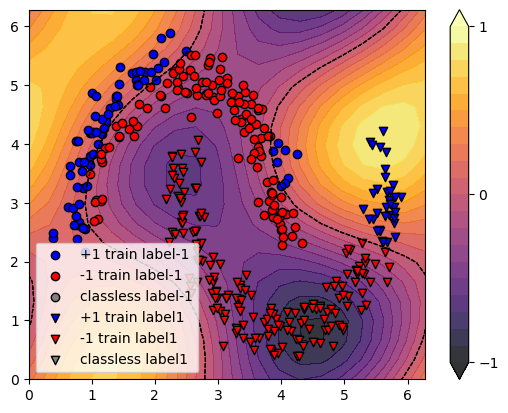

In [39]:
NumberOfQubits = 2
NumberOfLayers = 3
adapt_circuits(NumberOfQubits, NumberOfLayers)

initial_weights = np_qml.random.randn(NumberOfLayers, NumberOfQubits, 3, requires_grad=True)
data = get_moon_data(n_samples=400, noise=0.1)
# data = get_artificial_data(n_features=NumberOfQubits)
print_decision_region(*data, qnode, x_max=2*np.pi, y_max=2*np.pi, weights=initial_weights, bias=initial_bias)

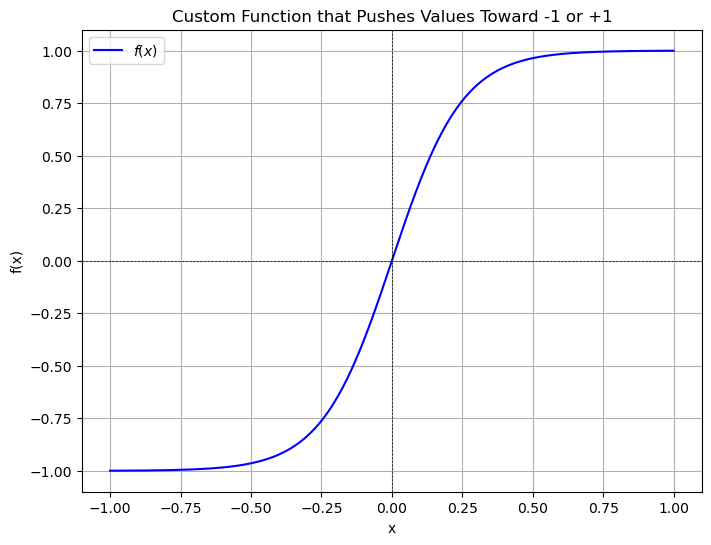

In [281]:

def custom_function(x):
    if x < 0:
        return -1 + (1 + x) / (1 - x)
    else:
        return 1 - (1 - x) / (1 + x)

# Vectorize the function for array inputs
custom_function = np.vectorize(custom_function)

# Generate data
x = np.linspace(-1, 1, 1000)
# y = custom_function(x)
y = tanh_function(x, k=4) 

# Plot
plt.figure(figsize=(8, 6))
plt.plot(x, y, label=r"$f(x)$", color="blue")
plt.title("Custom Function that Pushes Values Toward -1 or +1")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.axhline(0, color="black", linestyle="--", linewidth=0.5)
plt.axvline(0, color="black", linestyle="--", linewidth=0.5)
plt.grid(True)
plt.legend()
plt.show()

# Métricas personalizadas

# Treinamento Code

In [42]:
def treino(qnode, X, y, seed=12, batch_size = 10, Steps = 100, imprimir=0, cost_metric = square_loss_silhouette, metricValidation = squared_loss):
  
  np_qml.random.seed(seed)
  opt = SPSAOptimizer(10)
  # opt = NesterovMomentumOptimizer(0.5)

  weights = np_qml.random.randn(NumberOfLayers, NumberOfQubits, 3, requires_grad=True)
  bias = np_qml.array([0.0], requires_grad=True)

  print(f" i \t| Validation \t| Cost") if imprimir else 0

  for i in range(Steps):
    idxs = np_qml.random.randint(0, len(X), (batch_size,))
    x_batch = X[idxs]
    y_batch = y[idxs]

    # Passa como parâmetro para o otimizador o conjunto de treino do batch
    arguments = [weights, bias, cost_metric, x_batch, y_batch] #weights, bias, metric, X_batch, y_batch):
    weights, _,_,_,_, = opt.step(cost, *arguments)
    print(i+1, end='\r')

    if imprimir > 0 and (i % (imprimir) == 0 or i == Steps-1):
      # Calcula os valores previstos pelo modelo
      predictions_val = [np_qml.sign(classifier(qnode,weights, bias, xi)) for xi in X]

      acc = metricValidation(X,predictions_val,y)
      idxs = np_qml.random.randint(0, len(X), (batch_size,))
      arguments = [weights, bias, cost_metric, x_batch, y_batch]
      custo = cost(*arguments)

      print(f"{i+1:3d} \t| {np.mean(acc):0.5f} \t| {np.mean(custo):0.5f}")
      print_decision_region(X, y, qnode, x_max=2*np.pi, y_max=2*np.pi, weights=weights, bias=bias)

  return weights, bias

NumberOfQubits = 2
NumberOfLayers = 3
adapt_circuits(NumberOfQubits, NumberOfLayers)


# Treinamento testes

In [ ]:
X, Y = get_artificial_data(seed=127)
ww2, bb2 = treino(qnode, X, Y, batch_size = 50, Steps = 50, imprimir=20, seed=273, cost_metric=graph_metric_modularity)

 i 	| Validation 	| Cost
  1 	| 2.00000 	| 0.75390


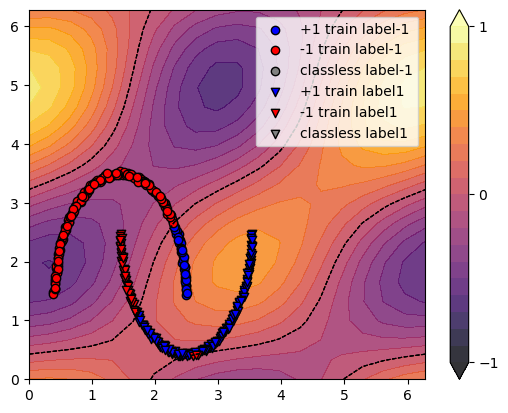

 31 	| 2.00000 	| 0.58095


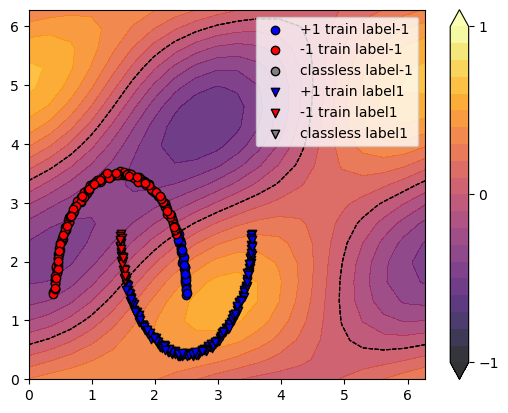

 61 	| 2.00000 	| 0.52289


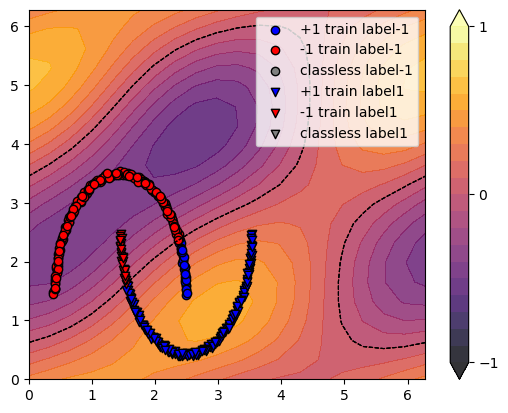

 91 	| 2.00000 	| 0.70473


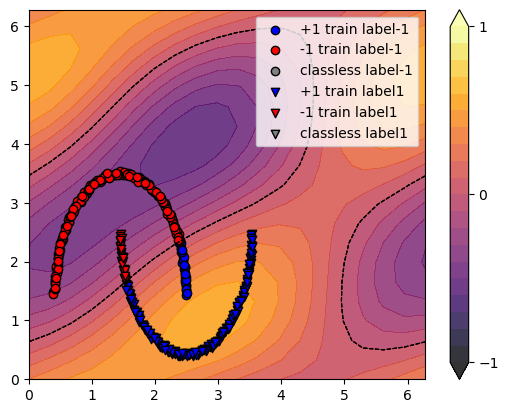

121 	| 2.00000 	| 0.36956


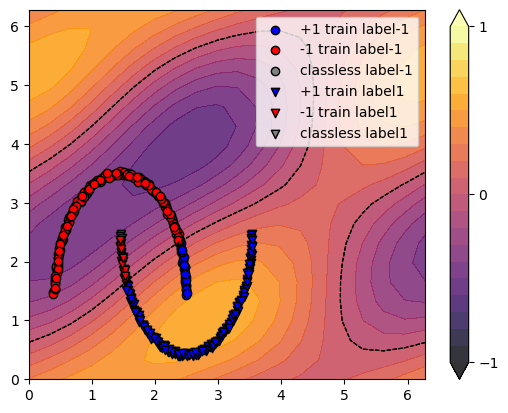

150 	| 2.00000 	| 0.50135


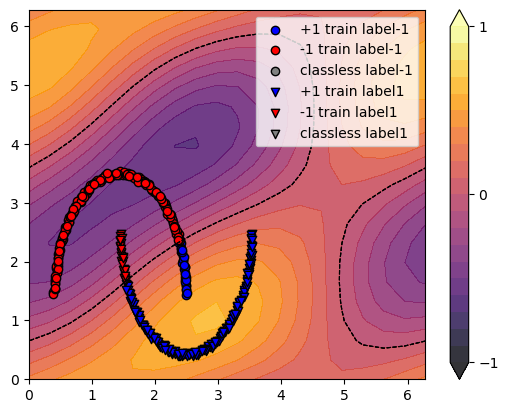

In [107]:
# NumberOfQubits = 3
# NumberOfLayers = 4
# adapt_circuits(NumberOfQubits, NumberOfLayers)
X, Y = get_moon_data(n_samples=400, noise=0.01)
ww, bb = treino(qnode, X, Y, batch_size = 30, Steps = 150, imprimir=30, seed=3, cost_metric=squared_loss)

 i 	| Validation 	| Cost
  1 	| 2.00000 	| -0.35962


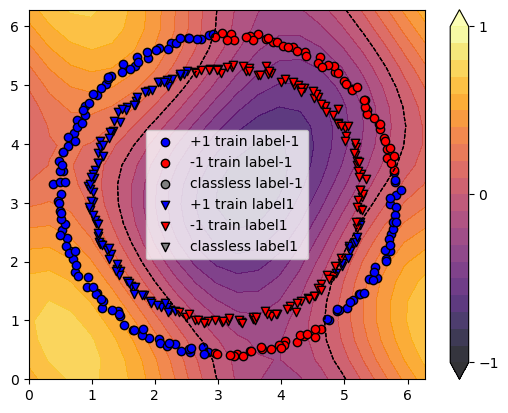

 31 	| 2.00000 	| -0.37671


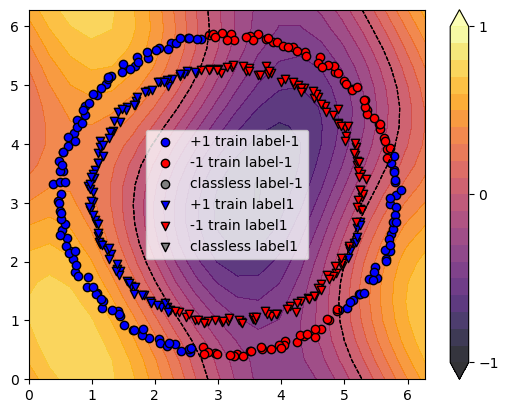

 61 	| 2.00000 	| -0.27637


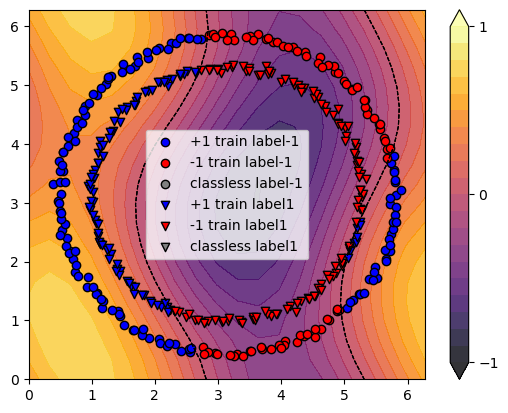

 91 	| 2.00000 	| -0.39038


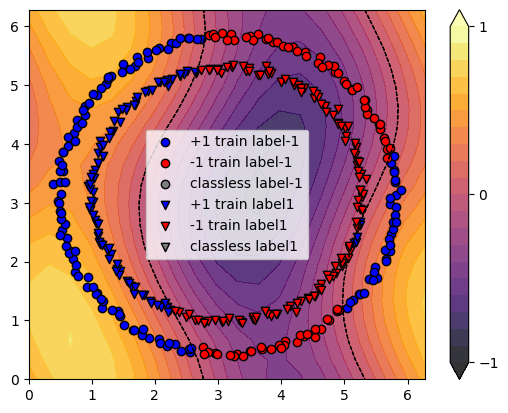

121 	| 2.00000 	| -0.35083


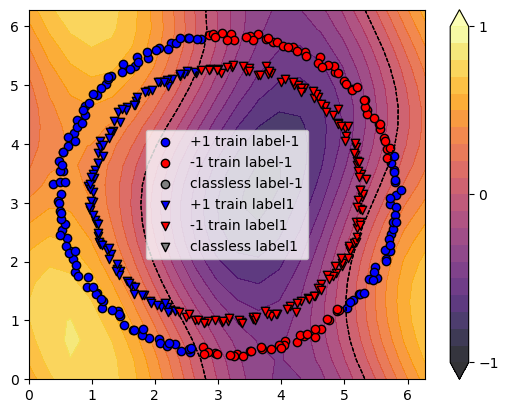

150 	| 2.00000 	| -0.33179


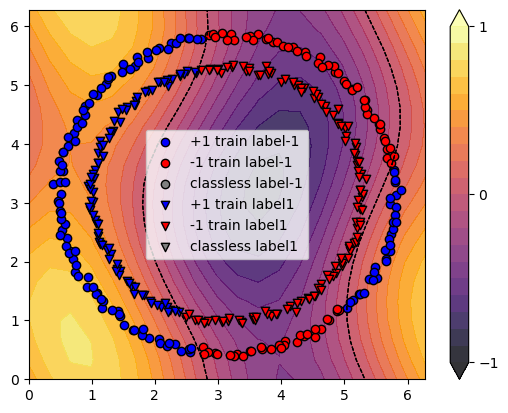

In [86]:
X, Y = get_circle_data(n_samples=400, noise=0.015)
ww, bb = treino(qnode, X, Y, batch_size = 50, Steps = 150, imprimir=30, seed=83, cost_metric=graph_metric_modularity)

In [ ]:
X, Y = get_artificial_data(seed=127)
ww2, bb2 = treino(qnode, X, Y, batch_size = 50, Steps = 50, imprimir=100, seed=273)